# MNIST Active Learning POC

General idea: Achieve the highest possible accuracy, with the lowest amount of train data using (supervised learning).

We start from a pool of unlabeled data and a test set. Then, we itiretaively query new samples to be annotated, and re-train the model.

In [ ]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from scipy import stats

import collections

## MNIST

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


## Baseline model

In [24]:
# the batch size will be used as the number of new images to annotate
BATCH_SIZE = 128
BASELINE_EPOCHS = 6
VALIDATION_SPLIT = 0.2

baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

baseline_model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=BASELINE_EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Epoch 1/6
375/375 [==============================] - 1s 3ms/step - loss: 0.3897 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.2073 - val_sparse_categorical_accuracy: 0.9435
Epoch 2/6
375/375 [==============================] - 1s 2ms/step - loss: 0.1841 - sparse_categorical_accuracy: 0.9480 - val_loss: 0.1583 - val_sparse_categorical_accuracy: 0.9553
Epoch 3/6
375/375 [==============================] - 1s 2ms/step - loss: 0.1352 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.1315 - val_sparse_categorical_accuracy: 0.9623
Epoch 4/6
375/375 [==============================] - 1s 2ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.1171 - val_sparse_categorical_accuracy: 0.9654
Epoch 5/6
375/375 [==============================] - 1s 2ms/step - loss: 0.0865 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.1105 - val_sparse_categorical_accuracy: 0.9661
Epoch 6/6
375/375 [==============================] - 1s 2ms/step - loss: 0.0714 - sparse_categorical_accu

In [25]:
_, baseline_metrics = baseline_model.evaluate(
    x=x_test,
    y=y_test,
)

print("SparseCategoricalAccuracy", baseline_metrics)

313/313 [==============================] - 0s 936us/step - loss: 0.0881 - sparse_categorical_accuracy: 0.9728
SparseCategoricalAccuracy 0.9728000164031982


## Randomly Added Images

In [40]:
INIT_SIZE = int(len(x_train) * 0.01)
print("Initial number of annotated images", INIT_SIZE, "out of", len(x_train))

BUDGET = BASELINE_EPOCHS * len(x_train)
print("The budget consists of", BUDGET, "forward passes")

ACTIVE_EPOCHS = 1
print("Every round, the network is trained for", ACTIVE_EPOCHS, "epoch(s)")

Initial number of annotated images 600 out of 60000
The budget consists of 360000 forward passes
Every round, the network is trained for 1 epoch(s)


In [41]:
annotated_ix = list()

annotated_ix = annotated_ix + np.random.choice(range(len(x_train)), 
                                               size=INIT_SIZE, replace=False).tolist()

x_train_annotated = x_train[annotated_ix]    
y_train_annotated = y_train[annotated_ix]

print("Size of initial set of annotated images", len(x_train_annotated))

random_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
random_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

random_model.fit(
    x=x_train_annotated,
    y=y_train_annotated,
    batch_size=BATCH_SIZE,
    epochs=ACTIVE_EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

random_spent = ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
print(random_spent, "out of", BUDGET, "forward passes done")

Size of initial set of annotated images 600
4/4 [==============================] - 0s 37ms/step - loss: 2.1860 - sparse_categorical_accuracy: 0.2562 - val_loss: 1.8542 - val_sparse_categorical_accuracy: 0.5417
480.0 out of 360000 forward passes done


In [42]:
_, metrics = random_model.evaluate(
    x=x_test,
    y=y_test,
)

print("SparseCategoricalAccuracy", metrics)

random_metrics = [metrics]
random_budget = [random_spent]
random_annotated = [len(x_train_annotated)]

313/313 [==============================] - 0s 959us/step - loss: 1.8851 - sparse_categorical_accuracy: 0.4947
SparseCategoricalAccuracy 0.49470001459121704


In [ ]:
while random_spent < BUDGET:
    ix_pool = np.delete(range(len(x_train)), annotated_ix)

    annotated_ix = annotated_ix + np.random.choice(ix_pool, 
                                                   size=BATCH_SIZE, replace=False).tolist()

    x_train_annotated = x_train[annotated_ix]    
    y_train_annotated = y_train[annotated_ix]

    random_model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    random_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    random_model.fit(
        x=x_train_annotated,
        y=y_train_annotated,
        batch_size=BATCH_SIZE,
        epochs=ACTIVE_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    _, metrics = random_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=0,
    )

    # print("SparseCategoricalAccuracy", metrics, "on", len(x_train_annotated), "annotated images")

    random_metrics.append(metrics)
    
    random_spent = random_spent + ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
    # print(random_spent, "out of", BUDGET, "forward passes done")
    random_budget.append(random_spent)
    random_annotated.append(len(x_train_annotated))

The following plot shows the accuracy on test achieved by the model after *n* forward passess (training). The solid red line shows the accuracy achieved by the model using 100% of the trianing data after trianing for an equivalent time (i.e. the same number of forward passess).

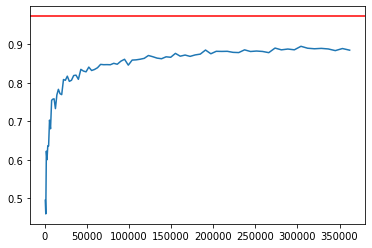

In [44]:
plt.plot(random_budget, random_metrics)
plt.axhline(baseline_metrics, color='r')

The following plot shows the accuracy on test achieved by the model usign *x*% of annotated training data (incrementally). The solid red line shows the accuracy achieved by the model using 100% of the trianing data after trianing for an equivalent time (i.e. the same number of forward passess).

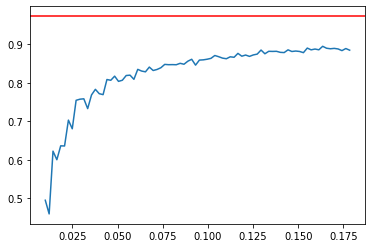

In [48]:
random_annotated_perc = np.array(random_annotated) / len(x_train)
plt.plot(random_annotated_perc, random_metrics)
plt.axhline(baseline_metrics, color='r')

## Clustering

In [92]:
x_train_flat = np.reshape(
    x_train, 
    (len(x_train), x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
)

# TODO: the number of cluster should be adjusted using internal/external validation metrics
N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(x_train_flat)


In [93]:
def norm_ratios(
    labels,
    sum_up_to,
    classes,
    inclusion=True):
    """ Given an array of classes (labels), returns an array of
    elements per class (ratio) that sum up to a given number.
    In other words, the sum of all returned elements is equal to
    'sum_up_to'.
    """
    labels_counts = collections.Counter(labels)    

    # select a repersentative initial set of images to be annotated
    counts = list()
    for i in classes:
        counts.append(labels_counts[i])

    counts = np.array(counts)
    _min = counts.min() if counts.min() > 0 else 1
    
    counts = counts / _min
    counts = counts / counts.sum()
    counts = counts * sum_up_to
    counts = counts.astype(int)

    if inclusion:
        # to avoid smalls clusters to be left out, we add at least one element per cluster
        counts[counts == 0] = 1

    while counts.sum() != sum_up_to:
        if counts.sum() > sum_up_to:
            counts[counts.argmax()] = counts[counts.argmax()] - 1
        elif counts.sum() < sum_up_to:
            counts[counts.argmin()] = counts[counts.argmin()] + 1
            
    return counts

In [97]:
# we will use the number of elements per cluster to select the initial batch
counts = norm_ratios(kmeans.labels_, INIT_SIZE, range(N_CLUSTERS))
print("Images by class adjusted to sum up to the initial amount of annotated data",
      counts)

set_ix = list()
for i in range(len(counts)):
    pos = np.where(kmeans.labels_ == i)[0]
    set_ix = set_ix + np.random.choice(pos, size=counts[i], replace=False).tolist()
    
annotated_ix = set_ix.copy()

x_train_annotated = x_train[annotated_ix]    
y_train_annotated = y_train[annotated_ix]

print("Size of initial set of annotated images", len(x_train_annotated))

Images by class adjusted to sum up to the initial amount of annotated data [55 89 34 74 59 65 88 46 33 57]
Size of initial set of annotated images 600


In [98]:
active_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
active_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

active_model.fit(
    x=x_train_annotated,
    y=y_train_annotated,
    batch_size=BATCH_SIZE,
    epochs=ACTIVE_EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

active_spent = ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
print(active_spent, "out of", BUDGET, "forward passes done")

4/4 [==============================] - 0s 29ms/step - loss: 2.1959 - sparse_categorical_accuracy: 0.2354 - val_loss: 2.5975 - val_sparse_categorical_accuracy: 0.1917
480.0 out of 360000 forward passes done


In [99]:
_, metrics = active_model.evaluate(
    x=x_test,
    y=y_test,
)

print("SparseCategoricalAccuracy", metrics)

active_metrics = [metrics]
active_budget = [active_spent]
active_annotated = [len(x_train_annotated)]

313/313 [==============================] - 0s 656us/step - loss: 2.0446 - sparse_categorical_accuracy: 0.4054
SparseCategoricalAccuracy 0.40540000796318054


**NOTE:** Should we use the test data to check instead?

In [100]:
while active_spent < BUDGET:
    preds = active_model.predict(x_train_annotated)
    preds_class = np.argmax(preds, axis=1)
    misclassified_relative = np.where((preds_class - y_train_annotated)!=0)
    misclassified_pos = np.take(annotated_ix, misclassified_relative)
    misclassified_cluster_no = np.take(kmeans.labels_, misclassified_pos)

    # compute ratio of misclassified classes
    counts_active = norm_ratios(misclassified_cluster_no.ravel(), BATCH_SIZE, range(N_CLUSTERS))
    # print("Misclasification by class adjusted to sum up to a batch", counts_active)

    # select new images to annotate with the given ratios
    ix_pool = np.delete(kmeans.labels_, annotated_ix)

    set_ix = list()
    for i in range(len(counts_active)):
        pos = np.where(ix_pool == i)[0]
        set_ix = set_ix + np.random.choice(pos, size=counts_active[i], replace=False).tolist()

    # print("Adding", len(set_ix), "annotated images")

    annotated_ix = annotated_ix + set_ix

    x_train_annotated = x_train[annotated_ix]    
    y_train_annotated = y_train[annotated_ix]

    # print("Current size of set of annotated images", len(x_train_annotated))
    
    active_model.fit(
        x=x_train_annotated,
        y=y_train_annotated,
        batch_size=BATCH_SIZE,
        epochs=ACTIVE_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    _, metrics = active_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=0,
    )

    # print("SparseCategoricalAccuracy", metrics)

    active_metrics.append(metrics)
    active_spent = active_spent + ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
    # print(random_spent, "out of", BUDGET, "forward passes done")
    active_budget.append(active_spent)
    active_annotated.append(len(x_train_annotated))

## Results Compared

First, as a sanity check, we train from *scratch* the same model using the annotated data.

In [101]:
cmp_epochs = int(BUDGET / len(x_train_annotated))

cmp_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
cmp_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

cmp_model.fit(
    x=x_train_annotated,
    y=y_train_annotated,
    batch_size=BATCH_SIZE,
    epochs=cmp_epochs,
    validation_split=VALIDATION_SPLIT,
    verbose=0,
)

_, cmp_metrics = cmp_model.evaluate(
    x=x_test,
    y=y_test,
    verbose=0,
)

print("SparseCategoricalAccuracy", cmp_metrics)

SparseCategoricalAccuracy 0.951200008392334


In [102]:
annotated_perc = len(x_train_annotated) / len(x_train)
annotated_perc = int(annotated_perc * 100)

print('Baseline (100% data)', baseline_metrics)
print('Baseline (', annotated_perc, '% data)', cmp_metrics)
print('Random (', annotated_perc, '% data)',random_metrics[-1])
print('Active (', annotated_perc, '% data)',active_metrics[-1])

Baseline (100% data) 0.9728000164031982
Baseline ( 17 % data) 0.951200008392334
Random ( 17 % data) 0.8845999836921692
Active ( 17 % data) 0.9498000144958496


The following plot shows the accuracy on test achieved by the model after *n* forward passess (training) using the active selection approach (*green*), and the random approach (*blue*). The solid red line shows the accuracy achieved by the model using 100% of the trianing data and the *annotated* data (*yellow*) after trianing for an equivalent time (i.e. the same number of forward passess) from scratch.

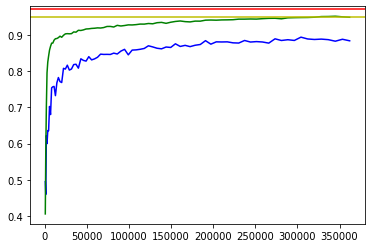

In [103]:
if np.sum(np.array(random_budget) - np.array(active_budget)) != 0:
    print("Error: The random and active budgets do not match")

if np.sum(np.array(random_annotated) - np.array(active_annotated)) != 0:
    print("Error: The random and active annotated counts do not match")

plt.plot(random_budget, random_metrics, color='b')
plt.plot(random_budget, active_metrics, color='g')
plt.axhline(baseline_metrics, color='r')
plt.axhline(cmp_metrics, color='y')

The following plot shows the accuracy on test achieved by the model usign *x*% of annotated training data with the active selection approach (*green*) and random (*blue*). The solid red line shows the accuracy achieved by the model using 100% of the trianing data and the *annotated* data (*yellow*) after trianing for an equivalent time (i.e. the same number of forward passess) from scratch.

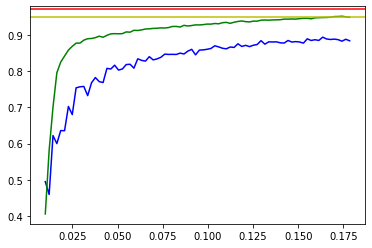

In [104]:
plt.plot(random_annotated_perc, random_metrics, color='b')
plt.plot(random_annotated_perc, active_metrics, color='g')
plt.axhline(baseline_metrics, color='r')
plt.axhline(cmp_metrics, color='y')

# Achieve P% Accuracy

In [116]:
P = 0.9
target_accuracy = baseline_metrics * P
print('Target accuracy', target_accuracy, '(', P, '%)')

Target accuracy 0.8755200147628784 ( 0.9 %)


In [130]:
def active_cluster(
    x_train,
    y_train,
    p_batch_size,
    p_epochs,
    p_init,
    n_clusters,
    target_accuracy):
    """
    """
    x_train_flat = np.reshape(
        x_train, 
        (len(x_train), x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
    )
    
    # TODO improve the N_CLUSTERS
    p_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x_train_flat)
    
    # we will use the number of elements per cluster to select the initial batch
    counts = norm_ratios(p_kmeans.labels_, p_init, range(n_clusters))

    set_ix = list()
    for i in range(len(counts)):
        pos = np.where(p_kmeans.labels_ == i)[0]
        set_ix = set_ix + np.random.choice(pos, size=counts[i], replace=False).tolist()

    annotated_ix = set_ix.copy()

    x_train_annotated = x_train[annotated_ix]    
    y_train_annotated = y_train[annotated_ix]

    p_model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    p_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    p_model.fit(
        x=x_train_annotated,
        y=y_train_annotated,
        batch_size=p_batch_size,
        epochs=p_epochs,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    p_spent = p_epochs * (1 - VALIDATION_SPLIT) * len(x_train_annotated)

    _, metrics = p_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=0,
    )

    p_metrics = [metrics]
    p_budget = [p_spent]
    p_annotated = [len(x_train_annotated)]

    while p_metrics[-1] < target_accuracy:
        preds = p_model.predict(x_train_annotated)
        preds_class = np.argmax(preds, axis=1)
        misclassified_relative = np.where((preds_class - y_train_annotated)!=0)
        misclassified_pos = np.take(annotated_ix, misclassified_relative)
        misclassified_cluster_no = np.take(p_kmeans.labels_, misclassified_pos)

        # compute ratio of misclassified classes
        counts_active = norm_ratios(
            misclassified_cluster_no.ravel(), 
            p_batch_size,
            range(n_clusters),
            inclusion=False)    

        # select new images to annotate with the given ratios
        ix_pool = np.delete(p_kmeans.labels_, annotated_ix)

        set_ix = list()
        for i in range(len(counts_active)):
            pos = np.where(ix_pool == i)[0]
            if len(pos) >= counts_active[i]:
                set_ix = set_ix + np.random.choice(pos, size=counts_active[i], replace=False).tolist()
            elif len(pos) > 0:
                set_ix = set_ix + pos

        annotated_ix = annotated_ix + set_ix

        x_train_annotated = x_train[annotated_ix]    
        y_train_annotated = y_train[annotated_ix]

        p_model.fit(
            x=x_train_annotated,
            y=y_train_annotated,
            batch_size=p_batch_size,
            epochs=p_epochs,
            validation_split=VALIDATION_SPLIT,
            verbose=0,
        )

        _, metrics = p_model.evaluate(
            x=x_test,
            y=y_test,
            verbose=0,
        )

        p_metrics.append(metrics)
        p_spent = p_spent + p_epochs * (1 - VALIDATION_SPLIT) * len(x_train_annotated)    
        p_budget.append(p_spent)
        p_annotated.append(len(x_train_annotated))

        if len(p_metrics) % 20 == 0:
            print(p_metrics[-1], p_annotated[-1])
            
    return p_metrics, p_budget, p_annotated


0.7009999752044678 115
0.7851999998092651 215
0.8226000070571899 315
0.8306000232696533 415
0.8557999730110168 515
0.8583999872207642 615


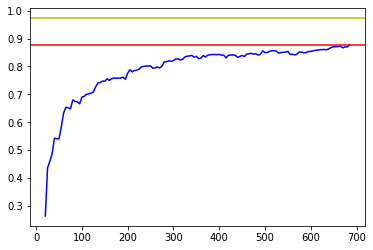

In [124]:
# p_metrics, p_budget, p_annotated
r0 = active_cluster(
    x_train,
    y_train,
    p_batch_size=5,
    p_epochs=6,
    p_init=20,
    n_clusters=10,
    target_accuracy=target_accuracy)

plt.plot(r1[2], r[0], color='b')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')

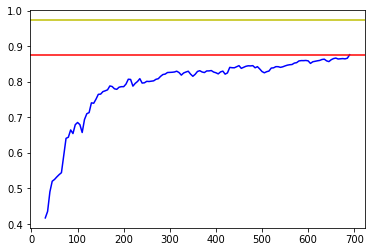

In [127]:
r1 = active_cluster(
    x_train,
    y_train,
    p_batch_size=5,
    p_epochs=10,
    p_init=30,
    n_clusters=10,
    target_accuracy=target_accuracy)

plt.plot(r1[2], r1[0], color='b')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')

0.7324000000953674 115
0.7976999878883362 215
0.8090999722480774 315
0.8551999926567078 415
0.8561000227928162 515


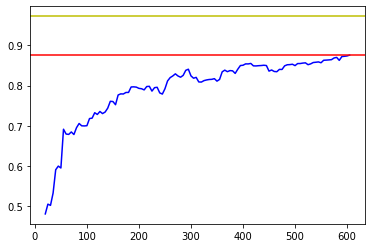

In [131]:
r2 = active_cluster(
    x_train,
    y_train,
    p_batch_size=5,
    p_epochs=20,
    p_init=20,
    n_clusters=10,
    target_accuracy=target_accuracy)

plt.plot(r2[2], r2[0], color='b')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')